# About

Here we analyze the PRS calculated on chromosome 16 using Neale's lab UKB GWAS.
We first visualize the GWAS by QQ-plot among LD-clumped SNPs.
Secondly, we load in PRS and the observed parent illness phenotypes.

# GWAS visualization

In [1]:
import pickle, gzip
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns


def load_pgz(fname):
    with gzip.open(fname, 'rb') as f:
        o = pickle.load(f)
    return o

def _check_dim_error(v, ndim):
    if len(v.shape) != ndim:
        raise ValueError(f'require {ndim}-d array.')

def get_rank(vec):
    '''
    1-d array
    '''
    _check_dim_error(vec, 1)
    seq = np.arange(vec.shape[0])
    tmp = vec.argsort(axis=0) 
    rank = np.zeros((vec.shape[0]))
    rank[tmp] = seq
    return rank

def pval_obs2expected(pval_list):
    '''
    pval_list is list of m length-n vectors
    calculate column by column
    '''
    for i in pval_list:
        _check_dim_error(i, 1)
    o = []
    for i in pval_list:
        o.append((get_rank(i) + 1) / i.shape[0])
    return o

def qqplot(pval, ax, col_labels=None):
    if col_labels is not None and len(pval) != len(col_labels):
        raise ValueError('pval and col_labels has different number of instances.')
        
    pexp = pval_obs2expected(pval)

#     fig, ax = plt.subplots(nrows=1, ncols=1)
    n = len(pval)
    for i in range(n):
        sort_idx = np.argsort(pexp[i])
        if col_labels is not None:
            kw = {'label': col_labels[i]}
        ax.plot(-np.log(pexp[i][sort_idx]), -np.log(pval[i][sort_idx]), **kw)
    if col_labels is not None:
        ax.legend()

# def parse_gwas_id(gwas_id):
#     '''
#     parse gwas long id into id and sex info.
#     '''
#     tmp = gwas_id.split('.')
#     return tmp[0], tmp[-1]

def p2chisq(p):
    return stats.norm.ppf(p / 2) ** 2

def get_median(gwas_code, gwas_dict, gwas_meta):
    gwas_codes = gwas_meta.gwas_id[gwas_meta.gwas_code == gwas_code].unique().tolist()
#     print(gwas_code)
    nums = []
    for code in gwas_codes:
        nums += gwas_dict[code]['pvalue'].tolist()
    nums = np.array(nums)
#     breakpoint()
    return np.median(p2chisq(nums))
    
def index_in_str_set(s, slist):
    for i in range(len(slist)):
        if s in slist[i]:
            return i, slist[i]
    return None, None


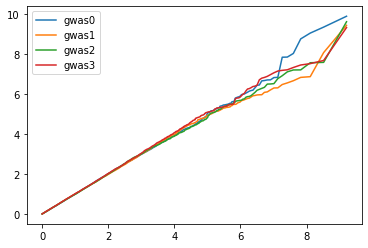

In [2]:
# test qqplot function
ngwas = 4
_, ax = plt.subplots(nrows=1, ncols=1)
qqplot(pval = [ np.random.uniform(size=(10000, )) for i in range(ngwas) ], ax=ax, col_labels=[ f'gwas{i}' for i in range(ngwas) ])
ax

In [3]:
gwas_dict_path = '/vol/bmd/yanyul/UKB/haplotype_imputation/prs/prs_naive.chr16.pgz'
gwas_meta_file = '../analysis_output/summary.gwas_neale_lab.csv'
gwas_meta_file_2 = '../analysis_output/analysis_batch.gwas_neale_lab.txt'
# drop gwas studies with duplicated gwas code
to_drop = ('20544_11.gwas.imputed_v3.both_sexes.v2', '20544_11.gwas.imputed_v3.male.v2', '20544_11.gwas.imputed_v3.female.v2')

prs_file_pattern = '/vol/bmd/yanyul/UKB/haplotype_imputation/prs/prs_naive.group{grp_num}.chr16.h5'

In [4]:
gwas_dict = load_pgz(gwas_dict_path)
gwas_meta_df = pd.read_csv(gwas_meta_file, index_col=0)
gwas_meta_df_2 = pd.read_csv(gwas_meta_file_2, sep='\t', header=None)
gwas_meta_df['gwas_id'] = gwas_meta_df_2[0].tolist()
gwas_meta_df = gwas_meta_df[ ~gwas_meta_df.gwas_id.isin(to_drop) ]

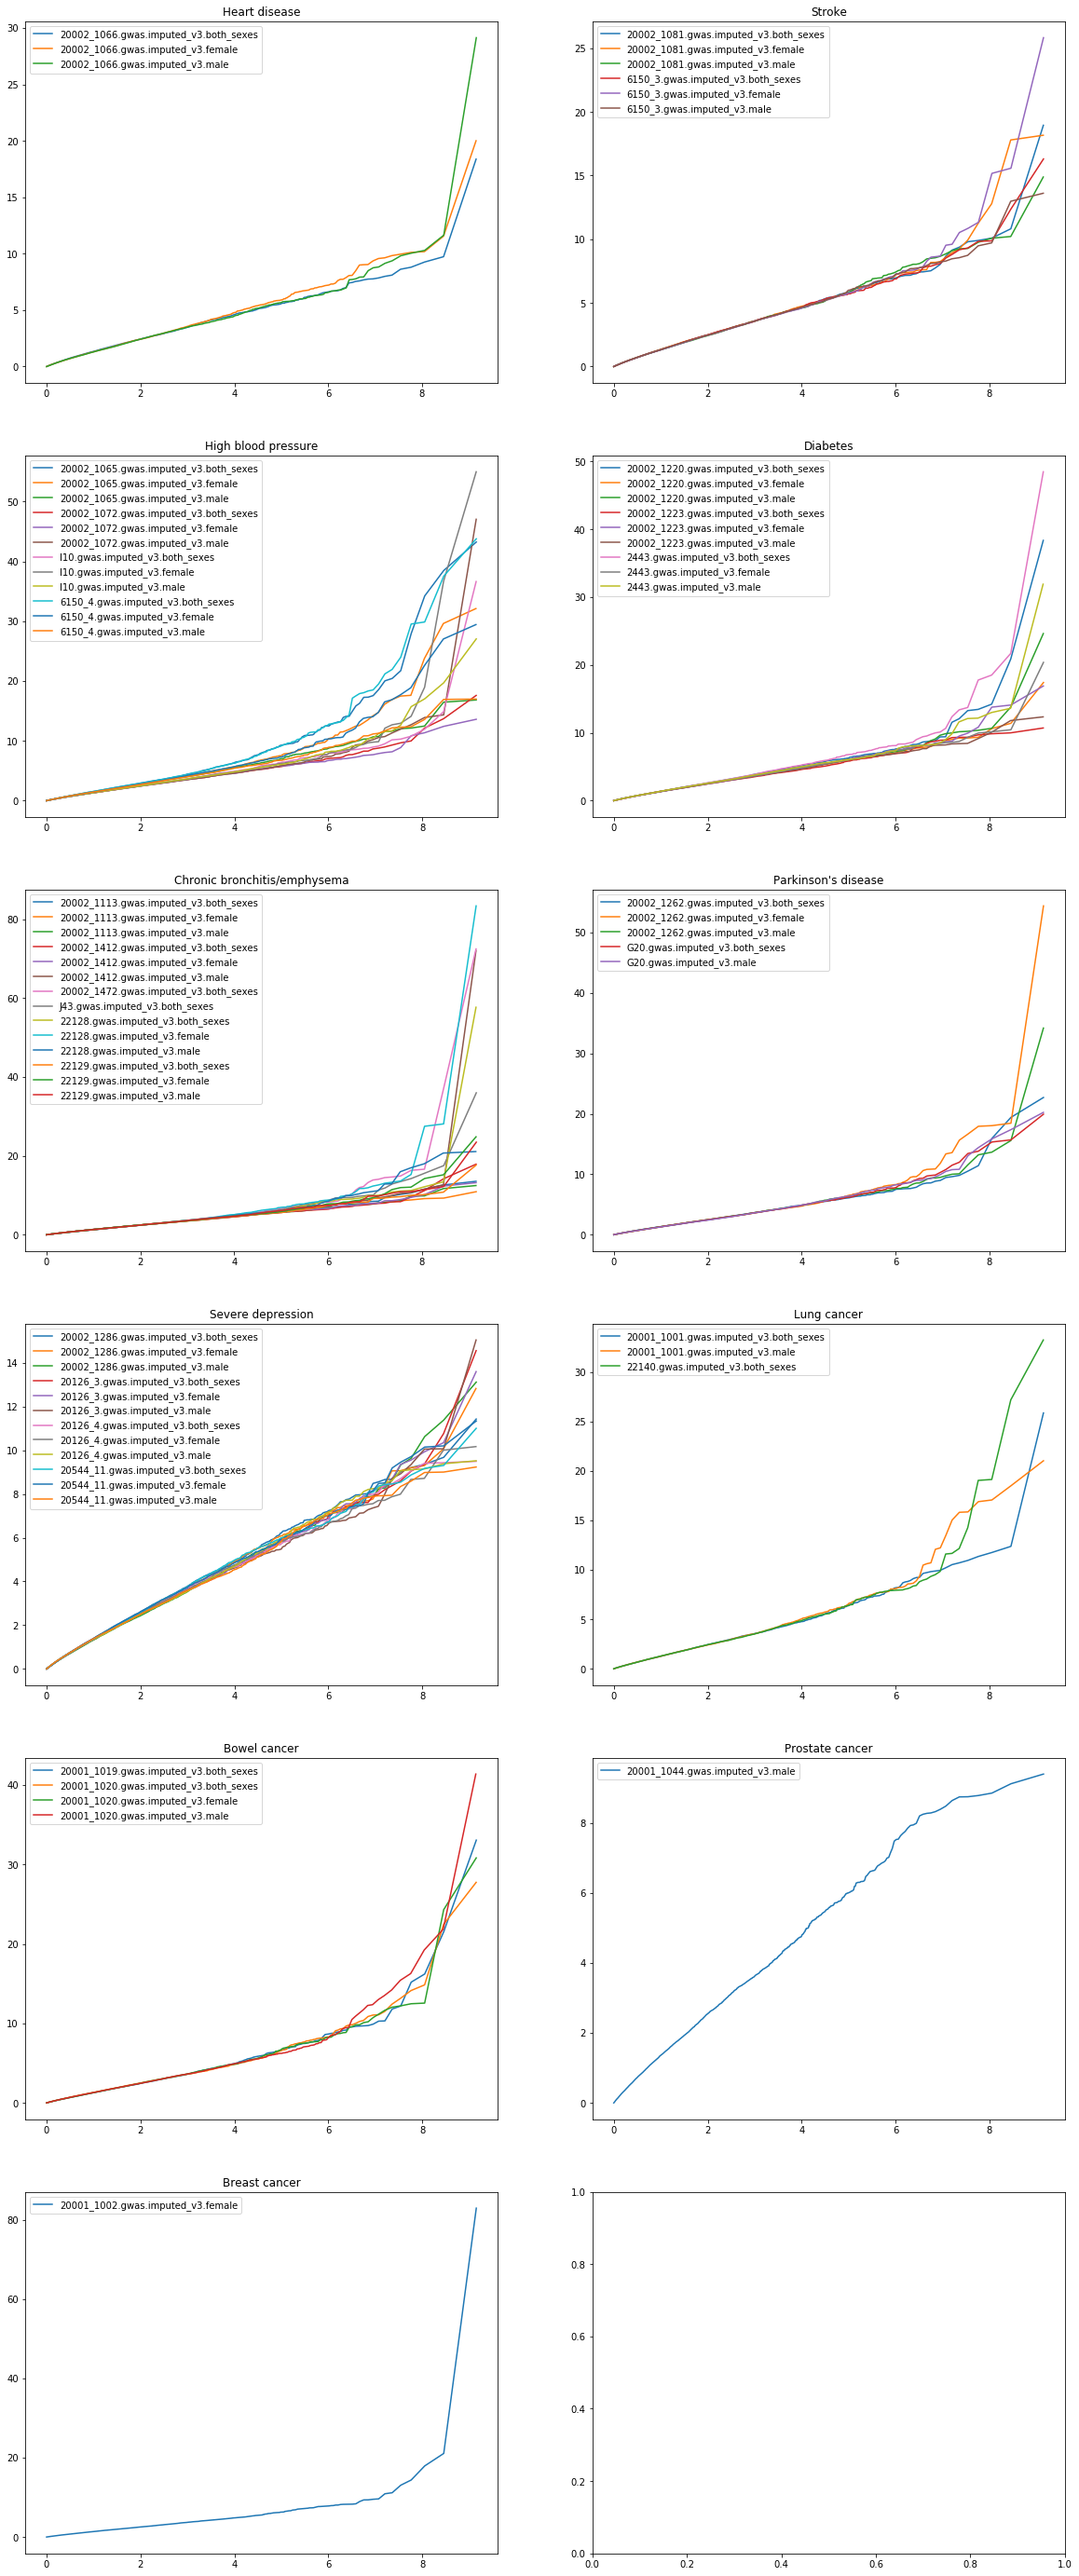

In [5]:
diseases = gwas_meta_df['disease'].unique().tolist()
disease_dic = { 
    i: gwas_meta_df.gwas_id[ gwas_meta_df.disease == i ].tolist()
    for i in diseases
}
fig, ax = plt.subplots(nrows=(len(diseases) + 1) // 2, ncols=2, figsize=(20, 50))
for i in range(len(diseases)):
    row_idx = i // 2
    col_idx = i % 2
    plist = [ np.array(gwas_dict[gwas]['pvalue'].tolist()) for gwas in disease_dic[diseases[i]] ]
    qqplot(plist, ax[row_idx][col_idx], col_labels=disease_dic[diseases[i]])
    ax[row_idx][col_idx].title.set_text(diseases[i])

For each disease, we'd like to select the GWASs with greatest significance. 

In [6]:
gwas_median_df = gwas_meta_df[['disease', 'gwas_code']].drop_duplicates(keep='first')
gwas_median_df['median_chi_sq'] = gwas_median_df['gwas_code'].map(lambda x: get_median(x, gwas_dict, gwas_meta_df))
ix = gwas_median_df.groupby(['disease'], sort=False)['median_chi_sq'].transform(max) == gwas_median_df['median_chi_sq']
gwas_selected_code = gwas_median_df[ix]
gwas_meta_selected_df = gwas_meta_df[ gwas_meta_df.gwas_code.isin(gwas_selected_code.gwas_code )].reset_index(drop=True)

In [7]:
gwas_meta_selected_df

,disease,gwas_code,Sex,wget.command,gwas_id
0,Heart disease,20002_1066,both_sexes,wget https://www.dropbox.com/s/cl6pi45us6xycdk...,20002_1066.gwas.imputed_v3.both_sexes
1,Heart disease,20002_1066,female,wget https://www.dropbox.com/s/cz7hj65bclueko8...,20002_1066.gwas.imputed_v3.female
2,Heart disease,20002_1066,male,wget https://www.dropbox.com/s/4aloscxkg897zkr...,20002_1066.gwas.imputed_v3.male
3,Stroke,6150_3,both_sexes,wget https://www.dropbox.com/s/7valgsltafbr8vi...,6150_3.gwas.imputed_v3.both_sexes
4,Stroke,6150_3,female,wget https://www.dropbox.com/s/vfonhfg5ahtxiqd...,6150_3.gwas.imputed_v3.female
5,Stroke,6150_3,male,wget https://www.dropbox.com/s/mazl1rkpwa7up7e...,6150_3.gwas.imputed_v3.male
6,High blood pressure,20002_1065,both_sexes,wget https://www.dropbox.com/s/m8qlfp0cjnn4ka7...,20002_1065.gwas.imputed_v3.both_sexes
7,High blood pressure,20002_1065,female,wget https://www.dropbox.com/s/u01pg3chw17j8tj...,20002_1065.gwas.imputed_v3.female
8,High blood pressure,20002_1065,male,wget https://www.dropbox.com/s/6d4bu8czuclvrl7...,20002_1065.gwas.imputed_v3.male
9,Diabetes,2443,both_sexes,wget https://www.dropbox.com/s/1i26ho0uycr5dcw...,2443.gwas.imputed_v3.both_sexes


Redo QQ-plots. 

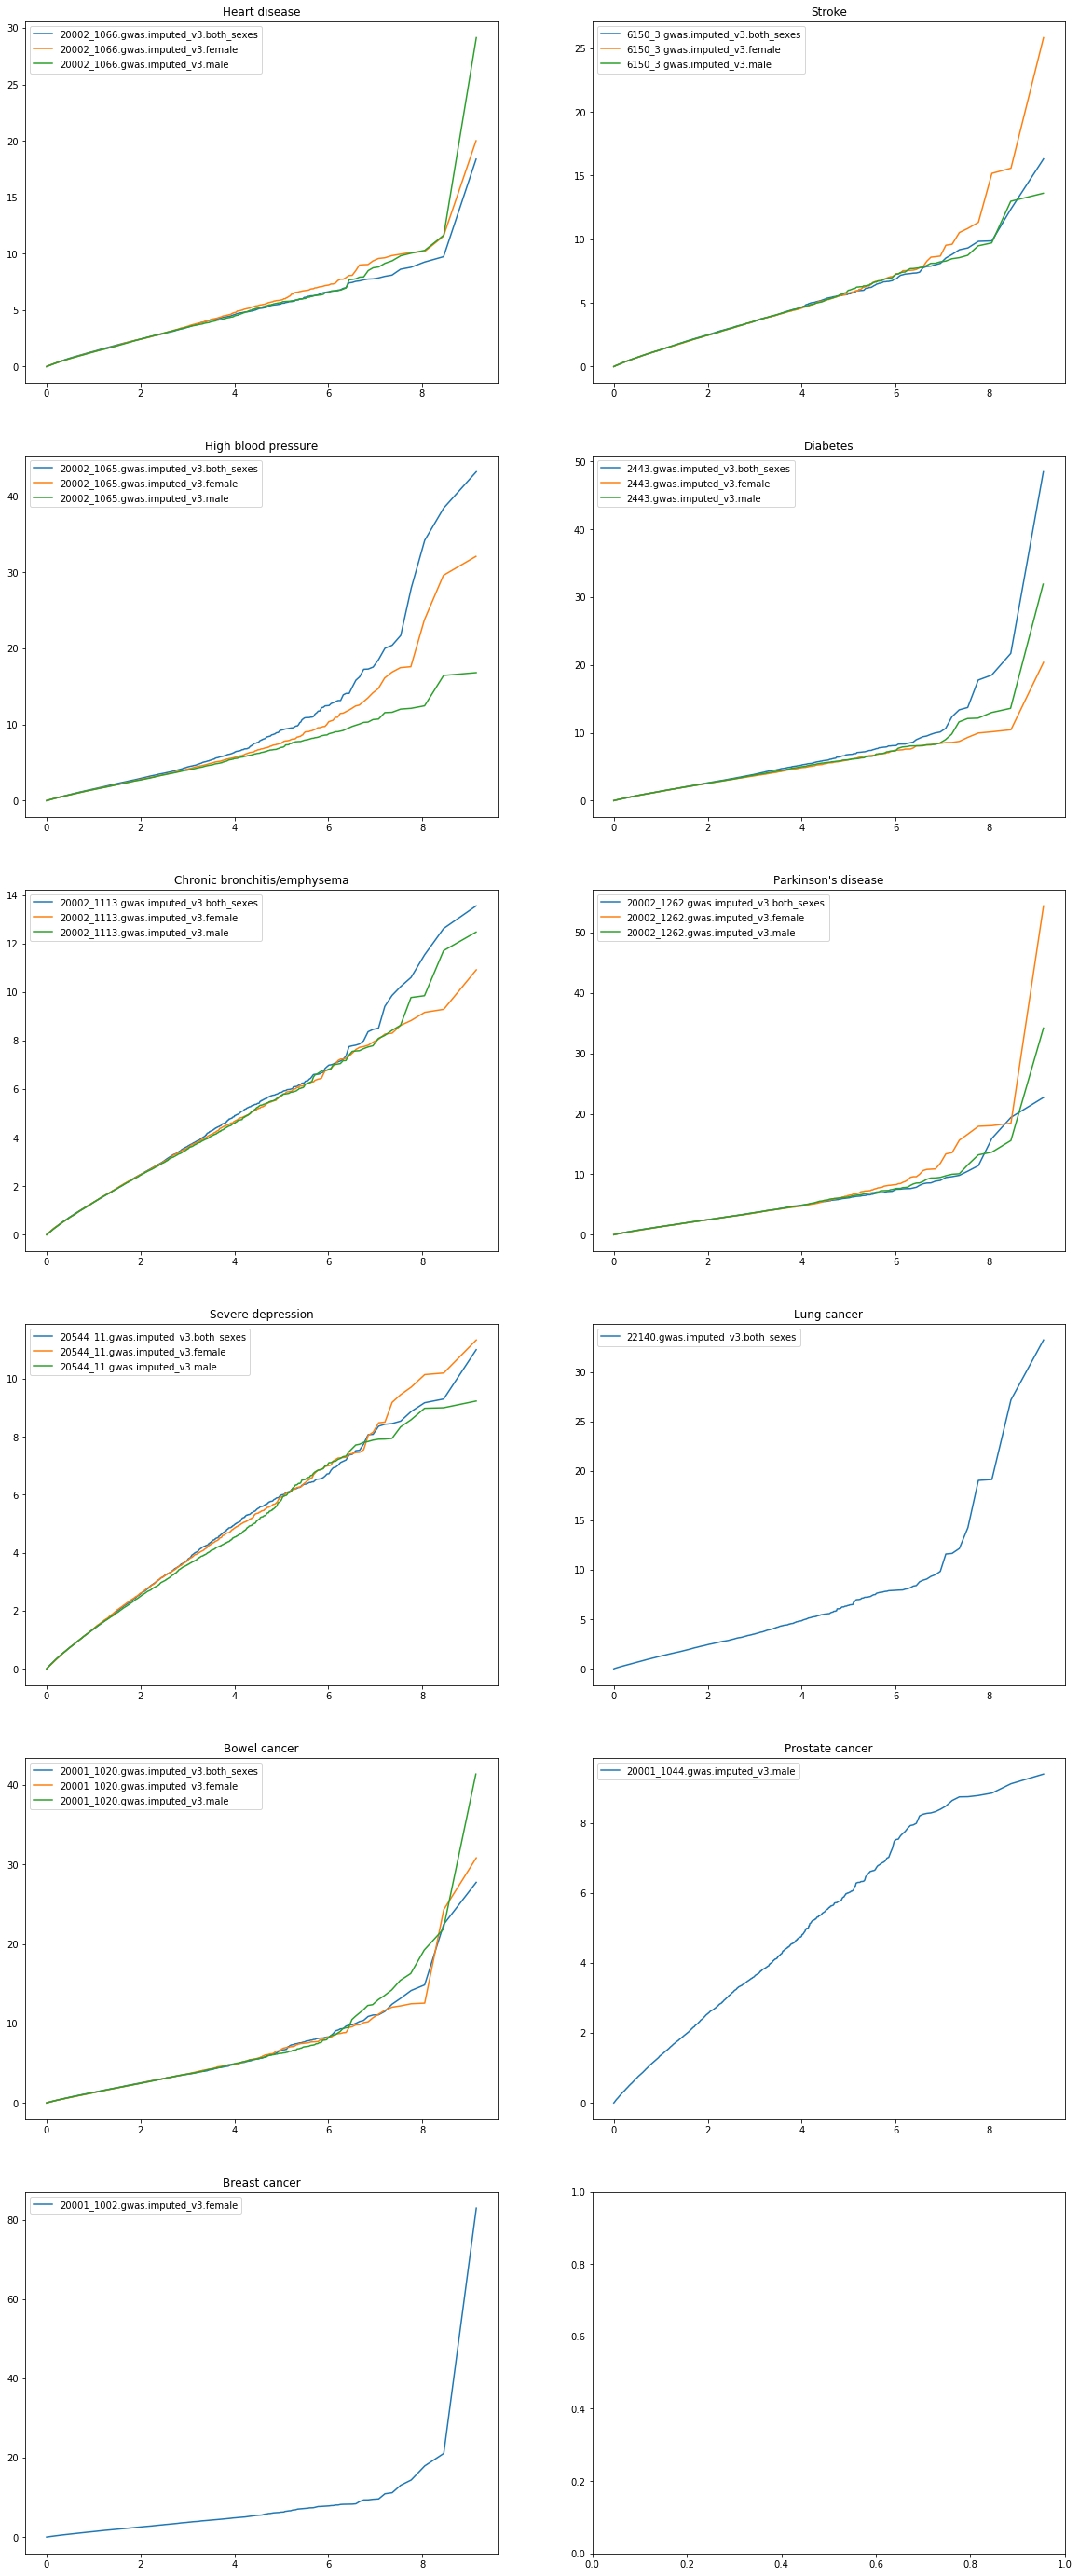

In [8]:
diseases = gwas_meta_selected_df['disease'].unique().tolist()
disease_dic = { 
    i: gwas_meta_selected_df.gwas_id[ gwas_meta_selected_df.disease == i ].tolist()
    for i in diseases
}
fig, ax = plt.subplots(nrows=(len(diseases) + 1) // 2, ncols=2, figsize=(20, 50))
for i in range(len(diseases)):
    row_idx = i // 2
    col_idx = i % 2
    plist = [ np.array(gwas_dict[gwas]['pvalue'].tolist()) for gwas in disease_dic[diseases[i]] ]
    qqplot(plist, ax[row_idx][col_idx], col_labels=disease_dic[diseases[i]])
    ax[row_idx][col_idx].title.set_text(diseases[i])

We focus on the selected GWAS for subsequent analysis.

# Load phenotype table

In [9]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

readRDS = robjects.r['readRDS']
df = readRDS('../analysis_output/parent_illness_2nd_european_phenotypes_clean_up.rds')
df_father = pandas2ri.ri2py(df[0])
df_mother = pandas2ri.ri2py(df[1])

/vol/bmd/yanyul/miniconda3/envs/haplotype_po/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [10]:
df_father.eid = df_father.eid.astype(int).astype(str)
df_mother.eid = df_mother.eid.astype(int).astype(str)


For simplicity, I draw a random subset (50k) of the individuals.

In [11]:
# nindiv = 310000
# individual_list = np.random.choice(df_father.eid.tolist(), size=nindiv, replace=False)
individual_list = df_father.eid.tolist()
df_father = df_father[ df_father.eid.isin(individual_list) ].reset_index(drop=True)
df_mother = df_mother[ df_mother.eid.isin(individual_list) ].reset_index(drop=True)

In [12]:
df_mother.columns = df_mother.columns.map(lambda x: x.split('(')[0].strip())
df_father.columns = df_father.columns.map(lambda x: x.split('(')[0].strip())

# Extract PRS

Load all runs into memory. 
For the sake of simplicity, I extract the PRS at p-value cutoff = 0.05

In [13]:
# set up index 
pval = 0.05
target_pool = gwas_meta_selected_df.gwas_id.tolist()
with h5py.File(prs_file_pattern.format(grp_num = 1), 'r') as f:
    p_idx = np.where(pval == f['pval_cutoffs'][:])[0][0]
    indiv_ind = np.where(np.isin(f['samples'][:], individual_list))[0]
    indiv_list = f['samples'][:][indiv_ind]

In [14]:
prs_h1_df = pd.DataFrame()
prs_h2_df = pd.DataFrame()
for i in range(1, 11):
    print(f'on group {i}')
    with h5py.File(prs_file_pattern.format(grp_num = i), 'r') as f:
        traits = f['traits'][:].astype(str)
        idx = []
        names = []
        for i in range(len(traits)):
            x, y = index_in_str_set(traits[i], target_pool)
            if x is not None:
                idx.append(i)
                names.append(y)
        prs = f['prs'][:, idx, p_idx, :]   
        prs = prs[indiv_ind, :, :]     
        prs_h1_df = pd.concat([prs_h1_df, pd.DataFrame(prs[:, :, 0], columns=names)], axis=1)    
        prs_h2_df = pd.concat([prs_h2_df, pd.DataFrame(prs[:, :, 1], columns=names)], axis=1)
prs_h1_df['eid'] = indiv_list.astype(str)
prs_h2_df['eid'] = indiv_list.astype(str)

on group 1
on group 2
on group 3
on group 4
on group 5
on group 6
on group 7
on group 8
on group 9
on group 10


For now, I limit to GWAS on both sexes.

In [15]:
gwas_meta_both_sexes_df = gwas_meta_selected_df[ gwas_meta_selected_df.Sex == 'both_sexes' ]
prs_h1_df = prs_h1_df[['eid'] + gwas_meta_both_sexes_df.gwas_id.tolist() ]
prs_h2_df = prs_h2_df[['eid'] + gwas_meta_both_sexes_df.gwas_id.tolist() ]
prs_h1_df.columns = ['eid'] + pd.merge(prs_h1_df.columns.to_frame(), gwas_meta_both_sexes_df, left_on=0, right_on='gwas_id').disease.tolist()
prs_h2_df.columns = ['eid'] + pd.merge(prs_h2_df.columns.to_frame(), gwas_meta_both_sexes_df, left_on=0, right_on='gwas_id').disease.tolist()

# Parental illness vs PRS

Here we look at:

For each trait, count the number of cases, and against haplotypic PRS. 

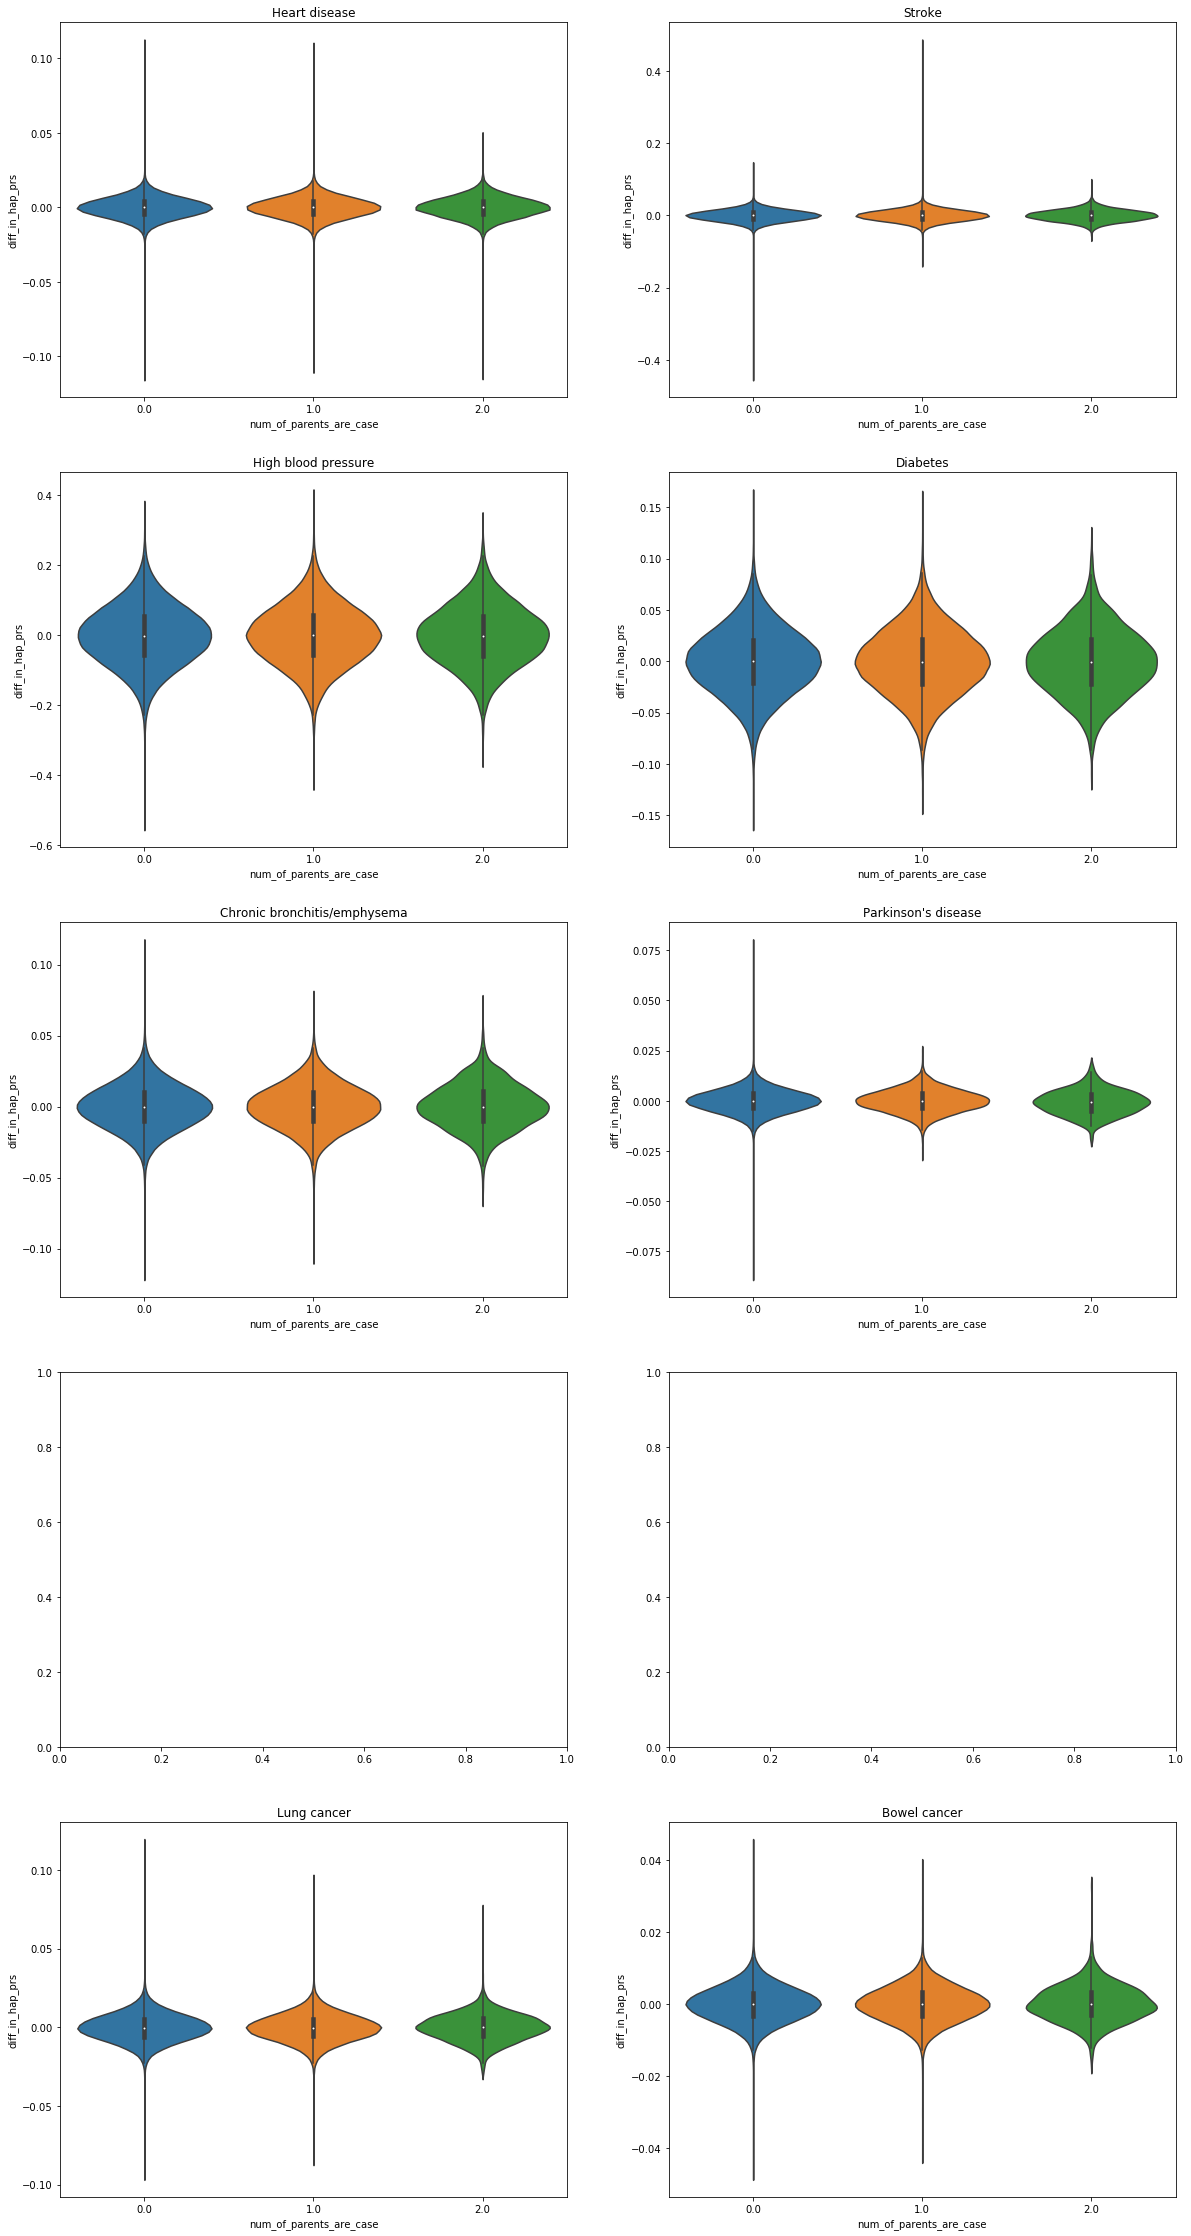

In [16]:
fsuffix = '_father'
msuffix = '_mother'
h1suffix = '_prs_h1'
h2suffix = '_prs_h2'

diseases = prs_h1_df.columns.tolist(); diseases.pop(0)
f, axes = plt.subplots(nrows=(len(diseases) + 1) // 2, ncols=2, figsize=(20, 40))

for i in range(len(diseases)):
    row_idx = i // 2
    col_idx = i % 2
    trait = diseases[i]
    if trait == 'Severe depression':
        continue

    sub = df_father[['eid', trait]]
    sub = pd.merge(sub, df_mother[['eid', trait]], left_on='eid', right_on='eid', suffixes=[fsuffix, msuffix])
    sub = pd.merge(sub, prs_h1_df[['eid', trait]].add_suffix(h1suffix), left_on='eid', right_on='eid' + h1suffix)
    sub = pd.merge(sub, prs_h2_df[['eid', trait]].add_suffix(h2suffix), left_on='eid', right_on='eid' + h2suffix)
    sub = sub[ (sub[trait + fsuffix] != -2) & (sub[trait + msuffix] != -2 )]
    sub['num_of_parents_are_case'] = sub[trait + fsuffix] + sub[trait + msuffix]
    sub['diff_in_hap_prs'] = (sub[trait + h1suffix] - sub[trait + h2suffix])
#     plot_df = pd.concat([
#         sub[['num_of_parents_are_case', 'diff_in_hap_prs', trait + h1suffix]].rename(columns={trait + h1suffix: 'hap_prs'}).assign(haplotype = 1),
#         sub[['num_of_parents_are_case', 'diff_in_hap_prs', trait + h2suffix]].rename(columns={trait + h2suffix: 'hap_prs'}).assign(haplotype = 2)
#     ])
#     sns.violinplot(x="num_of_parents_are_case", y='hap_prs', hue='haplotype', data=plot_df, ax=axes[row_idx][col_idx]).set(title = trait)
    sns.violinplot(x="num_of_parents_are_case", y='diff_in_hap_prs', data=sub, ax=axes[row_idx][col_idx]).set(title = trait)

In [19]:
df_dict = {
    'father': df_father,
    'mother': df_mother,
    'prs1': prs_h1_df,
    'prs2': prs_h2_df
}
for d in df_dict.keys():
    df_dict[d].to_csv(f'ukb_eur.{d}.csv.gzip', index=False, compression='gzip')

In [21]:
!ls -l

total 32476
-rw-r--r-- 1 yanyul bmd    23934 Apr 19 09:44 01_build_snp_map.ipynb
-rw-r--r-- 1 yanyul bmd    41690 Apr 20 09:54 02_compute_prs.ipynb
-rw-r--r-- 1 yanyul bmd  1183314 Apr 22 22:26 03_prs_vs_observed.ipynb
-rw-r--r-- 1 yanyul bmd    34974 Apr 22 21:30 test_naive_prs.ipynb
-rw-r--r-- 1 yanyul bmd  1686281 Apr 21 15:08 test_prs.h5
-rw-r--r-- 1 yanyul bmd  2148557 Apr 22 22:25 ukb_eur.father.csv.gzip
-rw-r--r-- 1 yanyul bmd  2124137 Apr 22 22:25 ukb_eur.mother.csv.gzip
-rw-r--r-- 1 yanyul bmd 12920589 Apr 22 22:26 ukb_eur.prs1.csv.gzip
-rw-r--r-- 1 yanyul bmd 12913007 Apr 22 22:26 ukb_eur.prs2.csv.gzip
